In [1]:
import pandas as pd
import re
from bs4 import BeautifulSoup
import nltk
import spacy
import numpy as np
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Title** **Preprocessing**

In [2]:

# Function to check for HTML tags and remove them if found
def clean_text(text):
    if isinstance(text, str):
        if '<' in text and '>' in text:
            text = BeautifulSoup(text, "html.parser").get_text()
        # Remove special characters and extra spaces
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
        text = re.sub(r"\s+", " ", text).strip()
    return text

# Function to normalize text (convert to lowercase)
def normalize_text(text):
    return text.lower() if isinstance(text, str) else text

# Function to tokenize and remove stopwords using SpaCy
def tokenize_and_remove_stopwords(text):
    if isinstance(text, str):
        doc = nlp(text)
        tokens = [token.text for token in doc if not token.is_stop and token.is_alpha]
        return " ".join(tokens)
    return text

# Loading both the real and fake CSV files
df_fake = pd.read_csv('politifact_fake.csv')
df_real = pd.read_csv('politifact_real.csv')

# Clean, normalize, tokenize, and remove stop words for the 'title' columns
df_real['title'] = df_real['title'].apply(lambda x: tokenize_and_remove_stopwords(normalize_text(clean_text(x))))
df_fake['title'] = df_fake['title'].apply(lambda x: tokenize_and_remove_stopwords(normalize_text(clean_text(x))))

# Add labels to the datasets real = 0 and fake = 1
df_real['label'] = 0
df_fake['label'] = 1

# convert ids t o string coz the integer is to long
df_real['tweet_ids'] = df_real['tweet_ids'].astype(str)
df_fake['tweet_ids'] = df_fake['tweet_ids'].astype(str)

# Appending df_fake and df_real to create a single DataFrame
df_combined = pd.concat([df_fake, df_real], ignore_index=True)

# print(df_combined.head())

# Saving the combined DataFrame to a new CSV file
df_combined.to_csv('combined_cleaned_data.csv', index=False)


# NER with Spacy

In [27]:



# Load the dataset
df = pd.read_csv("combined_cleaned_data.csv")

# Function to extract entities and calculate counts
def extract_entities_spacy(text):
    if not isinstance(text, str) or text.strip() == "":
        return {"PERSON": 0, "ORG": 0, "GPE": 0}
    doc = nlp(text)
    entity_counts = {"PERSON": 0, "ORG": 0, "GPE": 0}
    for ent in doc.ents:
        if ent.label_ in entity_counts:
            entity_counts[ent.label_] += 1
    return entity_counts

# Process each title to extract entity counts
entity_data = df["title"].apply(extract_entities_spacy)

# Convert entity_data into a DataFrame and merge with the main DataFrame
entity_df = pd.DataFrame(entity_data.tolist())
df = pd.concat([df, entity_df], axis=1)

# Calculate popularity based on tweet_ids (assuming they're comma-separated)
df["popularity"] = df["tweet_ids"].apply(lambda x: len(str(x).split(",")) if pd.notna(x) else 0)

df.to_csv("news_with_popularity_and_ner.csv", index=False)



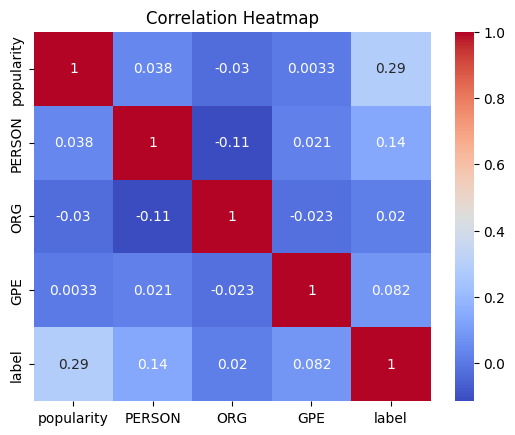

In [28]:
df = pd.read_csv("news_with_popularity_and_ner.csv")
if "label" in df.columns:
    correlation = df[["popularity", "PERSON", "ORG", "GPE", "label"]].corr()

    # Visualize the correlation
    sns.heatmap(correlation, annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()
else:
    print("No 'fake/1' column found. Correlation analysis is skipped.")


# Feature Engineering

In [9]:

# Load the dataset
df = pd.read_csv("news_with_popularity_and_ner.csv")

# Function to calculate article length
def calculate_article_length(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0
    return len(text.split())  # Count number of words

# Function to calculate sentiment scores
def calculate_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return {"polarity": 0, "subjectivity": 0}
    blob = TextBlob(text)
    return {"polarity": blob.sentiment.polarity, "subjectivity": blob.sentiment.subjectivity}

# Apply functions to the dataset
df["article_length"] = df["title"].apply(calculate_article_length)  # Assuming 'title' column contains the text
sentiment_data = df["title"].apply(calculate_sentiment)

# Convert sentiment data to a DataFrame and merge with the main DataFrame
sentiment_df = pd.DataFrame(sentiment_data.tolist())
df = pd.concat([df, sentiment_df], axis=1)

# Save the updated DataFrame
df.to_csv("news_with_article_length_and_sentiment.csv", index=False)

# Print a sample of the updated DataFrame
print(df.head())


                id                                           news_url  \
0  politifact15014          speedtalk.com/forum/viewtopic.php?t=51650   
1  politifact15156  politics2020.info/index.php/2018/03/13/court-o...   
2  politifact14745  www.nscdscamps.org/blog/category/parenting/467...   
3  politifact14355  https://howafrica.com/oscar-pistorius-attempts...   
4  politifact15371  http://washingtonsources.org/trump-votes-for-d...   

                                               title  \
0  breaking nfl team declares bankruptcy kneeling...   
1         court orders obama pay million restitution   
2  update second roy moore accuser works michelle...   
3            oscar pistorius attempts commit suicide   
4                      trump votes death penalty gay   

                                           tweet_ids  label  PERSON  ORG  GPE  \
0  937349434668498944\t937379378006282240\t937380...      1       0    0    0   
1  972666281441878016\t972678396575559680\t972827...      1   

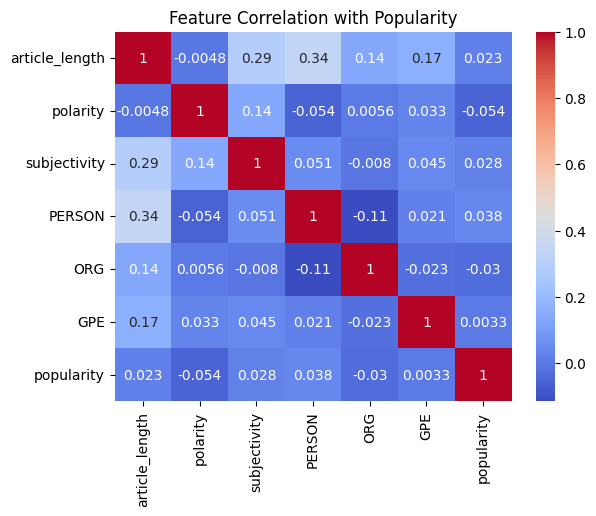

In [26]:
y = np.log1p(df["popularity"])  # Use log-transformed popularity
import seaborn as sns
corr = df[features + ["popularity"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Feature Correlation with Popularity")
plt.show()

# Result of the Popularity

   label      mean  median  count
0      0  0.655449     1.0    624
1      1  0.907407     1.0    432


<ipython-input-24-4ad964eb4370>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="label", y="popularity", palette="Set2", legend='false')


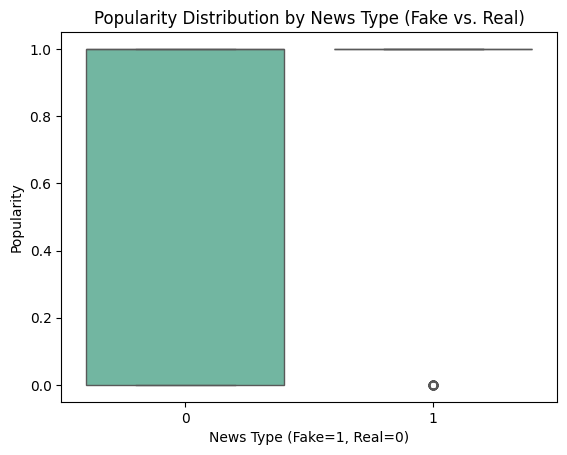

                id                                           news_url  \
0  politifact15014          speedtalk.com/forum/viewtopic.php?t=51650   
1  politifact15156  politics2020.info/index.php/2018/03/13/court-o...   
2  politifact14745  www.nscdscamps.org/blog/category/parenting/467...   
3  politifact14355  https://howafrica.com/oscar-pistorius-attempts...   
4  politifact15371  http://washingtonsources.org/trump-votes-for-d...   

                                               title  \
0  breaking nfl team declares bankruptcy kneeling...   
1         court orders obama pay million restitution   
2  update second roy moore accuser works michelle...   
3            oscar pistorius attempts commit suicide   
4                      trump votes death penalty gay   

                                           tweet_ids  label  PERSON  ORG  GPE  \
0  937349434668498944\t937379378006282240\t937380...      1       0    0    0   
1  972666281441878016\t972678396575559680\t972827...      1   

In [24]:
from scipy.stats import ttest_ind

df = pd.read_csv("news_with_article_length_and_sentiment.csv")

# Group by 'label' and compute mean and median popularity
popularity_stats = df.groupby("label")["popularity"].agg(["mean", "median", "count"]).reset_index()
print(popularity_stats)

# Visualize the distribution of popularity for fake and real news

sns.boxplot(data=df, x="label", y="popularity", palette="Set2", legend='false')
plt.title("Popularity Distribution by News Type (Fake vs. Real)")
plt.xlabel("News Type (Fake=1, Real=0)")
plt.ylabel("Popularity")
plt.show()
print(df.head())
# Statistical test: t-test for difference in means
fake_popularity = df[df["label"] == 1]["popularity"]
real_popularity = df[df["label"] == 0]["popularity"]

t_stat, p_value = ttest_ind(fake_popularity, real_popularity, equal_var=False)
print(f"T-Statistic: {t_stat:.3f}, P-Value: {p_value:.3e}")

# Optional: Correlation
correlation = df[["popularity", "label"]].corr().iloc[0, 1]
print(f"Correlation between Popularity and Fake/Real Label: {correlation:.3f}")
